# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tardiness
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60 * 5 # 5 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,0,9,49,1440
1,1,5,130,1440
2,2,3,151,1440
3,3,4,226,1440
4,4,6,386,1440
...,...,...,...,...
15,15,5,1142,1440
16,16,6,1254,1440
17,17,7,1285,1440
18,18,8,1397,1440


In [4]:
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,0,9,49,1440,2009.0
1,1,5,130,1440,2004.0
2,2,3,151,1440,2337.0
3,3,4,226,1440,1898.0
4,4,6,386,1440,2103.0
...,...,...,...,...,...
15,15,5,1142,1440,3016.0
16,16,6,1254,1440,2971.0
17,17,7,1285,1440,3243.0
18,18,8,1397,1440,3469.0


## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [5]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS",
                                          msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 2281.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~300 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,0,9,0,M01,85,49,1440,2009.0,1611.0,1696.0,0.0
1,0,9,1,M00,13,49,1440,2009.0,1696.0,1709.0,0.0
2,0,9,2,M02,61,49,1440,2009.0,1709.0,1770.0,0.0
3,0,9,3,M06,7,49,1440,2009.0,1770.0,1777.0,0.0
4,0,9,4,M08,64,49,1440,2009.0,1777.0,1841.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,19,9,5,M09,76,1398,1440,3358.0,3287.0,3363.0,5.0
196,19,9,6,M05,47,1398,1440,3358.0,3363.0,3410.0,52.0
197,19,9,7,M03,52,1398,1440,3358.0,3410.0,3462.0,104.0
198,19,9,8,M04,90,1398,1440,3358.0,3462.0,3552.0,194.0


In [ ]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

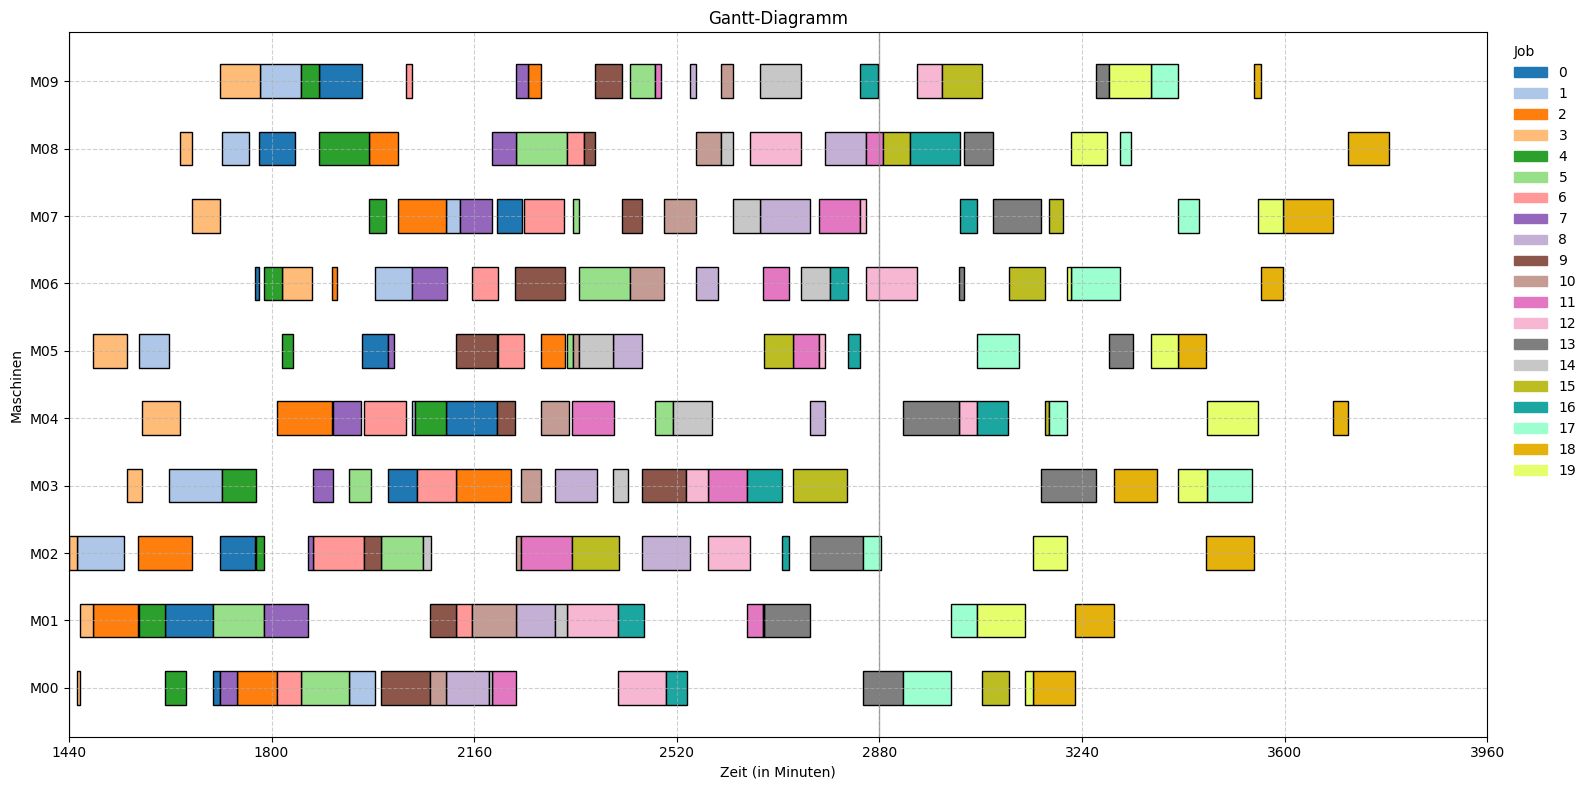

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [ ]:
# Scheduling
df_schedule = lp_tardiness.solve_jssp_max(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

In [ ]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

In [ ]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)